### Imports and settings

In [1]:
# imports and basic settings
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))  # if running in notebooks folder
DATA_DIR = os.path.join(BASE_DIR, "data", "health")
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

print("Base:", BASE_DIR)
print("Data dir:", DATA_DIR)
print("Model dir:", MODEL_DIR)

Base: C:\Users\user\Desktop\plant-project\plant-ai
Data dir: C:\Users\user\Desktop\plant-project\plant-ai\data\health
Model dir: C:\Users\user\Desktop\plant-project\plant-ai\models


### Dataset preview

Counts:
Healthy: 152
Diseased: 152


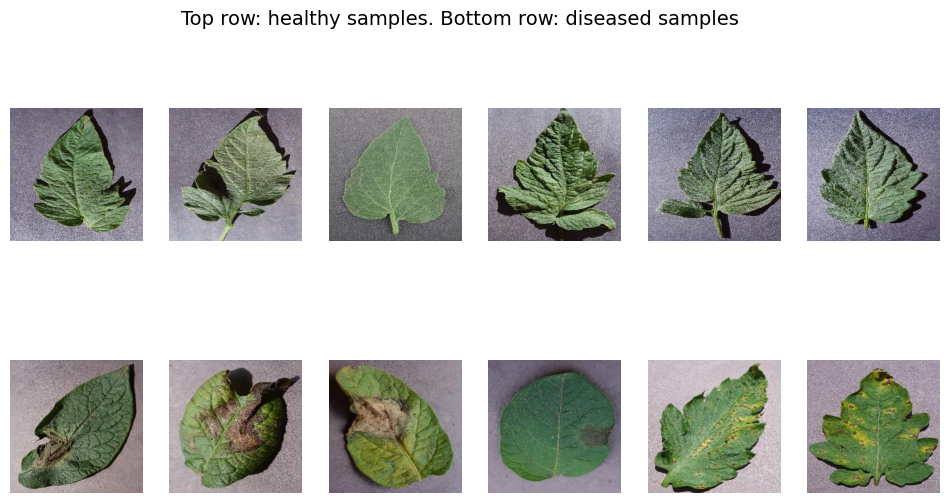

In [2]:
# show sample images from each class
import glob
from PIL import Image

def sample_images(class_folder, n=6):
    files = glob.glob(os.path.join(class_folder, "*"))
    files = files if len(files) <= n else random.sample(files, n)
    imgs = [Image.open(f) for f in files]
    return files, imgs

healthy_folder = os.path.join(DATA_DIR, "healthy")
diseased_folder = os.path.join(DATA_DIR, "diseased")

print("Counts:")
print("Healthy:", len(os.listdir(healthy_folder)))
print("Diseased:", len(os.listdir(diseased_folder)))

files_h, imgs_h = sample_images(healthy_folder, 6)
files_d, imgs_d = sample_images(diseased_folder, 6)

plt.figure(figsize=(12,6))
for i, img in enumerate(imgs_h+imgs_d):
    plt.subplot(2,6,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Top row: healthy samples. Bottom row: diseased samples", fontsize=14)
plt.show()

### Create TensorFlow datasets (train/val/test) and augmentation

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = seed

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# optionally create a small test set by splitting validation further or separate folder. 
# For simplicity, we'll use validation as our test during this quick iteration.

class_names = train_ds.class_names
print("Classes:", class_names)

# data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
])

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 304 files belonging to 2 classes.
Using 244 files for training.
Found 304 files belonging to 2 classes.
Using 60 files for validation.
Classes: ['diseased', 'healthy']


### Build the transfer learning model

In [4]:
# build the model using a pretrained backbone
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze the base for initial training

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)           # apply augmentation only during training
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # preprocessing for the backbone
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train

In [5]:
# train
EPOCHS = 5  # short for quick iteration; increase later
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 774ms/step - accuracy: 0.5041 - loss: 0.9116 - val_accuracy: 0.6333 - val_loss: 0.6839
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 591ms/step - accuracy: 0.5984 - loss: 0.6977 - val_accuracy: 0.6167 - val_loss: 0.6435
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - accuracy: 0.7213 - loss: 0.5877 - val_accuracy: 0.8333 - val_loss: 0.4908
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step - accuracy: 0.7377 - loss: 0.5128 - val_accuracy: 0.9000 - val_loss: 0.3941
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 610ms/step - accuracy: 0.8689 - loss: 0.3981 - val_accuracy: 0.9000 - val_loss: 0.3539


### Evaluation and confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification report:
              precision    recall  f1-score   support

    diseased       0.97      0.85      0.91        34
     healthy       0.83      0.96      0.89        26

    accuracy                           0.90        60
   macro avg       0.90      0.91      0.90        60
weighted avg       0.91      0.90      0.90        60



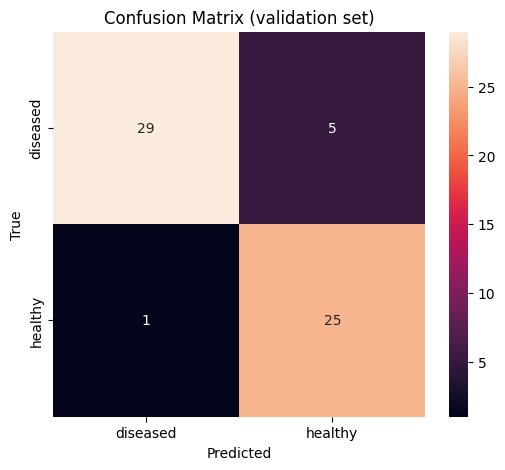

In [6]:
# create predictions on the validation (used as test) set and compute confusion matrix
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (validation set)")
plt.show()

### Sample predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


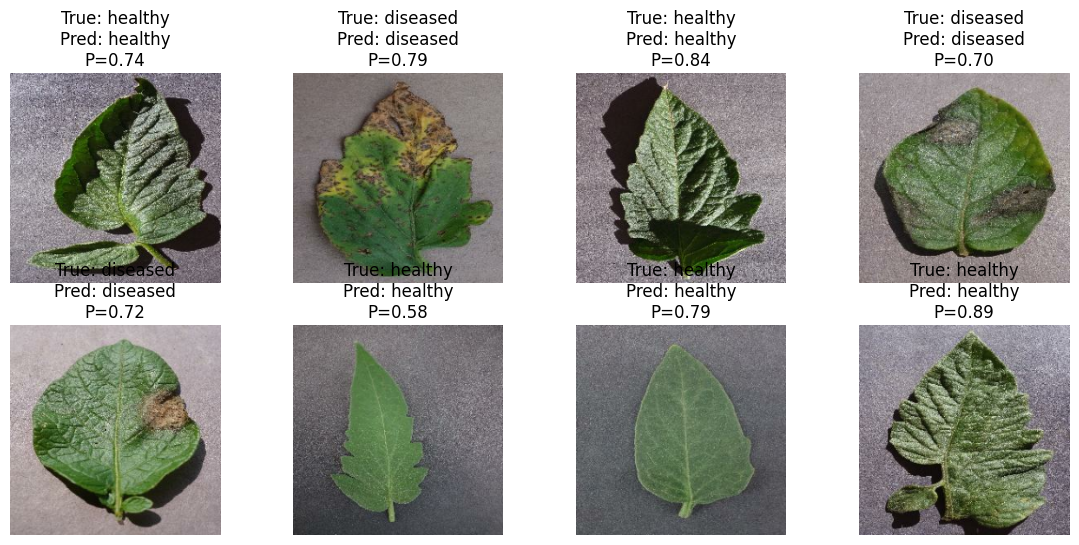

In [7]:
import itertools

# get a small batch from val_ds
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    probs = np.max(preds, axis=1)
    imgs = images.numpy()
    true_labels = labels.numpy()
    break

n = min(8, imgs.shape[0])
plt.figure(figsize=(14,6))
for i in range(n):
    plt.subplot(2,4,i+1)
    plt.imshow((imgs[i].astype("uint8")))
    title = f"True: {class_names[true_labels[i]]}\nPred: {class_names[preds_labels[i]]}\nP={probs[i]:.2f}"
    plt.title(title)
    plt.axis('off')
plt.show()

### Save the model & export class names

In [9]:
model_path = os.path.join(MODEL_DIR, "health_model.keras")
model.save(model_path)
print("Saved model to:", model_path)

# save class names
import json
with open(os.path.join(MODEL_DIR, "class_names.json"), "w") as f:
    json.dump(class_names, f)
print("Saved class names.")

Saved model to: C:\Users\user\Desktop\plant-project\plant-ai\models\health_model.keras
Saved class names.
